In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In the first part of the assignment, I tested the VAE using the Oxford IIIT Pet dataset.

Next, I interpolated between one latent space and another, visualizing the transition with the VAE.

In the last (3rd) part, I implemented the Deep Convolutional Generative Adversarial Network (DCGAN) on the same dataset and compared both.


Part-02 will be in a separate file

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset loading
train_dataset = OxfordIIITPet(root='datasets/', split='trainval', target_types='category',
                              download=True, transform=transform_train)
val_dataset = OxfordIIITPet(root='datasets/', split='test', target_types='category',
                            download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True)

100%|██████████| 792M/792M [00:40<00:00, 19.7MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.6MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


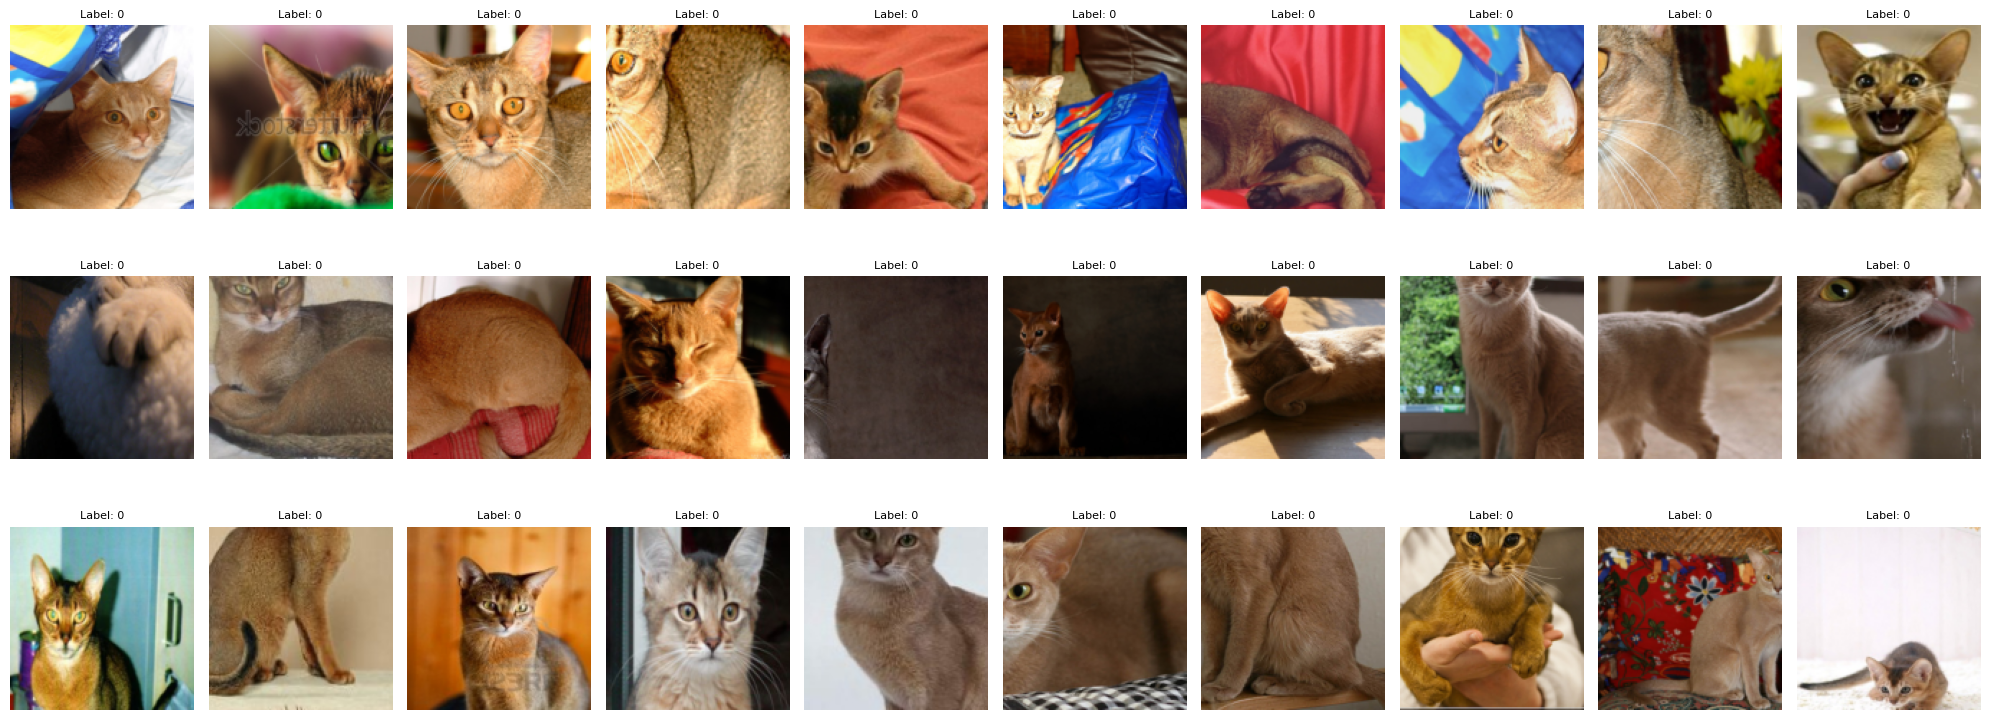

In [2]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 10, figsize=(20, 8))

for idx in range(30):
    image, label = train_dataset[idx]
    ax = axes[idx // 10, idx % 10]

    # Convert CHW to HWC and unnormalize if needed
    image = image.permute(1, 2, 0)  # CHW → HWC
    image = image * 0.5 + 0.5
    image = image.clamp(0, 1)

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Label: {label}", fontsize=8)

plt.tight_layout()
plt.show()

As we are using images, so convoluation VAE is a better option than traditional VAE. I also tried the traditional one, but the loss value is way bigger than the current one.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=200, img_channels=3, device='cuda'):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.device = device

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, stride=2, padding=1),  # 64x64
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 8x8
            nn.LeakyReLU(0.2),
        )

        self.flatten = nn.Flatten()
        self.feature_dim = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64x64
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, img_channels, 4, stride=2, padding=1),  # 128x128
            nn.Sigmoid()  # Output in [0, 1]
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [8]:
model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def loss_function(x, x_hat, mean, logvar):
    # Flatten inputs
    x = x.view(x.size(0), -1)
    x_hat = x_hat.view(x_hat.size(0), -1)

    # Reconstruction loss: MSE is more suitable for RGB images
    # Use reduction='mean' for calculating average loss per element in the batch
    # which is more standard for loss functions. If reduction='sum' is required,
    # the average calculation in the training loop needs adjustment.
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    # KL Divergence between learned latent distribution and standard normal
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    total_loss = reconstruction_loss + kl_divergence
    return total_loss


def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Handle the case where batch_idx might be 0 for small datasets
        avg_loss = overall_loss / (batch_idx * 64 if batch_idx > 0 else 64)
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", avg_loss)
    return overall_loss

total_loss = []
total_loss.append(train(model, optimizer, epochs=20, device=device))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


	Epoch 1 	Average Loss:  10174.951694421601
	Epoch 2 	Average Loss:  10088.84904399671
	Epoch 3 	Average Loss:  10122.15024499726
	Epoch 4 	Average Loss:  10123.933842173794
	Epoch 5 	Average Loss:  10074.389125890899
	Epoch 6 	Average Loss:  10053.513629043311
	Epoch 7 	Average Loss:  10015.314024808114
	Epoch 8 	Average Loss:  10003.994046395284
	Epoch 9 	Average Loss:  10007.437808388158
	Epoch 10 	Average Loss:  10051.67510450932
	Epoch 11 	Average Loss:  10082.579170093202
	Epoch 12 	Average Loss:  10008.548870956689
	Epoch 13 	Average Loss:  10127.809673108553
	Epoch 14 	Average Loss:  9904.062028851426
	Epoch 15 	Average Loss:  10020.29728618421
	Epoch 16 	Average Loss:  10020.422466077303
	Epoch 17 	Average Loss:  10018.050687020284
	Epoch 18 	Average Loss:  9996.202062774122
	Epoch 19 	Average Loss:  9931.243275424891
	Epoch 20 	Average Loss:  10020.983347039473


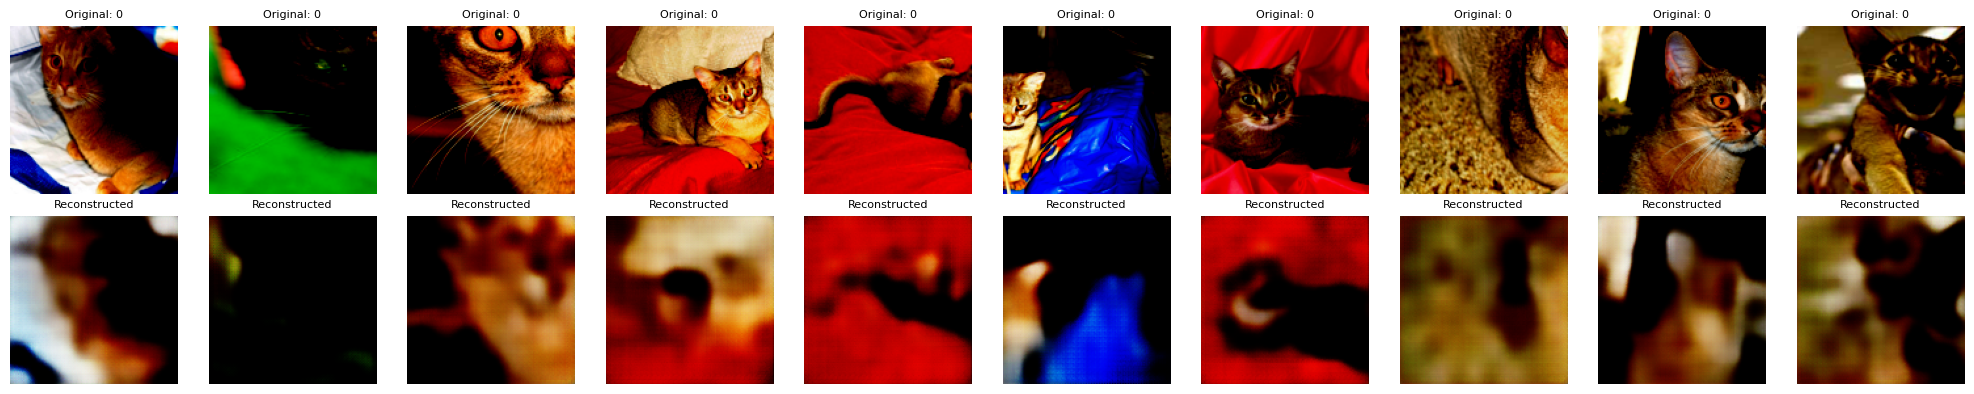

In [20]:
import matplotlib.pyplot as plt
import torch

num_images = 10
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))

model.eval()
for idx in range(num_images):
    image, label = train_dataset[idx]

    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        recon, _, _ = model(input_img)


    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0, idx].imshow(img_np)
    axes[0, idx].axis("off")
    axes[0, idx].set_title(f"Original: {label}", fontsize=8)

    recon_img_np = recon.squeeze(0).permute(1, 2, 0).cpu().numpy()
    axes[1, idx].imshow(recon_img_np)
    axes[1, idx].axis("off")
    axes[1, idx].set_title(f"Reconstructed", fontsize=8) # Added fontsize

plt.tight_layout()
plt.show()

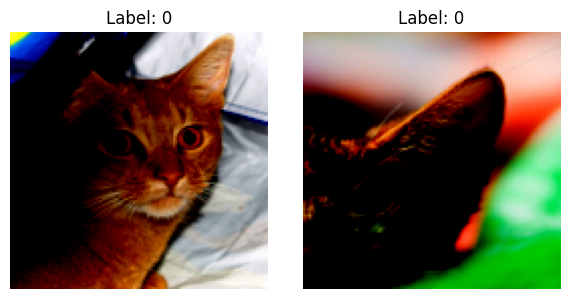

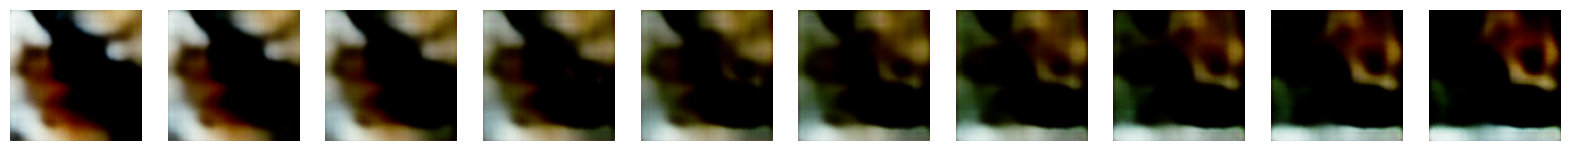

In [29]:
def interpolate_and_visualize(vae, img1, img2, steps=10):
    vae.eval()
    with torch.no_grad():
        mu1, _ = vae.encode(img1.unsqueeze(0))
        mu2, _ = vae.encode(img2.unsqueeze(0))
        interpolated = []
        for alpha in torch.linspace(0, 1, steps):
            z = mu1 * (1 - alpha) + mu2 * alpha
            recon = vae.decode(z).cpu().squeeze().permute(1, 2, 0).numpy()
            interpolated.append(recon)

        # Plot
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(1, steps, figsize=(20, 5))
        for idx in range(steps):
            axes[idx].imshow(interpolated[idx])
            axes[idx].axis('off')
        plt.show()

def original_image():
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for idx in range(2):
        image, label = train_dataset[idx]
        axes[idx].imshow(image.permute(1, 2, 0))
        axes[idx].set_title(f"Label: {label}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

original_image()

interpolate_and_visualize(model, train_dataset[0][0], train_dataset[1][0])



Now, we are implementing Deep Convolutional Generative Adversarial Network (DCGAN) on the same dataset

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 5


class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: (N, 100, 1, 1)
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),  # (N, 1024, 4, 4)
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),  # (N, 512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # (N, 256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # (N, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # (N, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),     # (N, 3, 128, 128)
            nn.Tanh()  # Output values in [-1, 1]
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: [batch, 3, 128, 128]
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),    # → [batch, 64, 64, 64]
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # → [batch, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # → [batch, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False), # → [batch, 512, 8, 8]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1, bias=False), # → [batch, 1024, 4, 4]
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),   # → [batch, 1, 1, 1]
            nn.Sigmoid()  # → probability real/fake
        )

    def forward(self, x):
        return self.main(x).view(-1)


# Initialize networks
generator = Generator()
discriminator = Discriminator()

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [11]:

# Training loop
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)

        # Train Discriminator
        discriminator.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()

        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_d.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item()}, g_loss: {g_loss.item()}')

Epoch [1/5], d_loss: 0.31269069015979767, g_loss: 3.415553569793701
Epoch [2/5], d_loss: 1.030199110507965, g_loss: 3.9870898723602295
Epoch [3/5], d_loss: 0.07082796096801758, g_loss: 4.35880708694458
Epoch [4/5], d_loss: 0.6541560292243958, g_loss: 4.457448959350586
Epoch [5/5], d_loss: 1.1840646117925644, g_loss: 3.9304122924804688


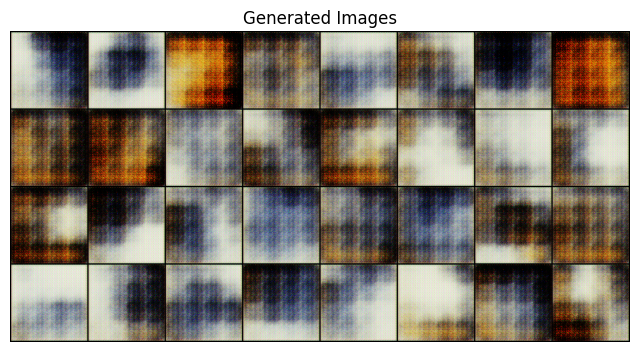

In [13]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

z = torch.randn(batch_size, latent_dim, 1, 1).to(device)


with torch.no_grad():
    fake_images = generator(z).detach().cpu()

# Plot a grid
grid = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(grid.permute(1, 2, 0))
plt.show()

From the image sharpness we can see that ConvVAE is perform better than DCGAN. There are multiple reason for this, training epoch is less for DCGAN.

